# Лабораторная работа №6: Классификация изображений
**Датасет**: Flowers Recognition (5 классов: ромашка, одуванчик, роза, подсолнух, тюльпан).  
**Цель**: Исследовать модели классификации (сверточные сети и трансформеры), создать и улучшить бейзлайн, реализовать собственную модель и сравнить результаты.  
**Метрики**: Accuracy (для общей оценки) и F1-score (для баланса precision/recall).

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используем устройство: {device}')

Используем устройство: cuda


## 1. Выбор начальных условий
Работаем с датасетом Flowers Recognition, который содержит изображения цветов 5 классов. Размер изображений приводится к 224x224, используются стандартные нормализации для моделей torchvision.

## 2. Выбор набора данных и обоснование
Датасет Flowers Recognition выбран из-за его практической значимости: классификация растений полезна в ботанике, сельском хозяйстве и приложениях для садоводов. 5 классов обеспечивают умеренную сложность задачи. Датасет доступен на Kaggle: https://www.kaggle.com/alxmamaev/flowers-recognition.

## 3. Выбор метрик качества
- **Accuracy**: Простая и интерпретируемая метрика, подходит для сбалансированного датасета.
- **F1-score**: Учитывает precision и recall, полезен для оценки качества по каждому классу, особенно если классы слегка несбалансированы.

Загрузи archive.zip


Saving archive.zip to archive.zip
Archive:  archive.zip
  inflating: ./flowers/flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: ./flowers/flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: ./flowers/flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: ./flowers/flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: ./flowers/flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: ./flowers/flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: ./flowers/flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: ./flowers/flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: ./flowers/flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: ./flowers/flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: ./flowers/flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: ./flowers/flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: ./flowers/flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: ./flowers/flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating

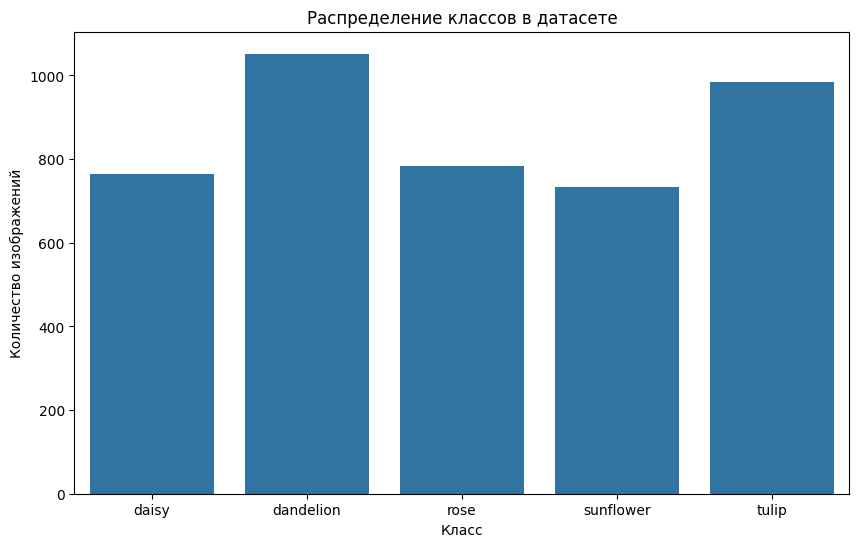

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from google.colab import files

print("Загрузи archive.zip")
uploaded = files.upload()

!unzip -o archive.zip -d ./flowers
!ls ./flowers
!ls ./flowers/flowers

classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
print(f'Классы: {classes}')

base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = './flowers/flowers'
dataset = ImageFolder(data_dir, transform=base_transform)
print(f"Классы датасета: {dataset.classes}")

train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

dataset_aug = ImageFolder(data_dir, transform=aug_transform)
train_set_aug, _ = train_test_split(dataset_aug, test_size=0.2, random_state=42)
train_loader_aug = DataLoader(train_set_aug, batch_size=32, shuffle=True)

class_counts = pd.Series(dataset.targets).value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks(ticks=range(len(classes)), labels=classes)
plt.title('Распределение классов в датасете')
plt.xlabel('Класс')
plt.ylabel('Количество изображений')
plt.show()

## 4. Создание бейзлайна и оценка качества
Создаём простую сверточную нейросеть (CNN) в качестве бейзлайна.

Эпоха 1/3: 100%|██████████| 108/108 [00:04<00:00, 24.89it/s]


Эпоха 1, Loss: 1.6589


Эпоха 2/3: 100%|██████████| 108/108 [00:03<00:00, 34.64it/s]


Эпоха 2, Loss: 1.0452


Эпоха 3/3: 100%|██████████| 108/108 [00:03<00:00, 33.97it/s]


Эпоха 3, Loss: 0.7978
Accuracy: 0.6076, F1-Score: 0.6071

Classification Report:
               precision    recall  f1-score   support

       daisy       0.70      0.57      0.63       162
   dandelion       0.63      0.71      0.67       223
        rose       0.44      0.65      0.52       155
   sunflower       0.70      0.70      0.70       135
       tulip       0.69      0.42      0.52       189

    accuracy                           0.61       864
   macro avg       0.63      0.61      0.61       864
weighted avg       0.63      0.61      0.61       864



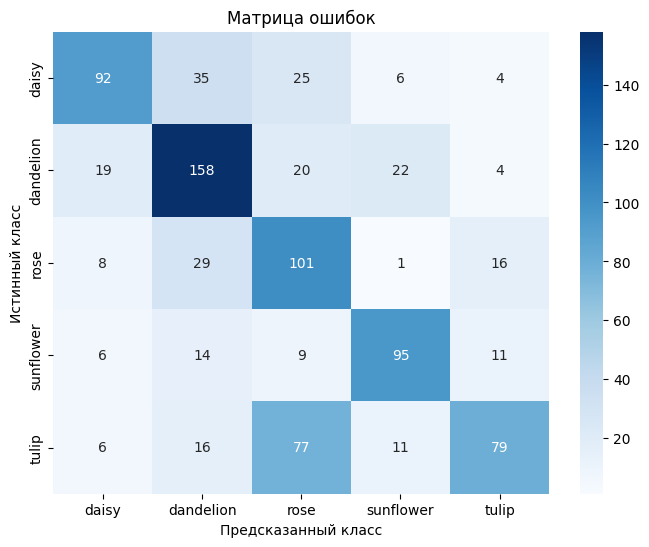

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def train_model(model, criterion, optimizer, train_loader, num_epochs=3):
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f'Эпоха {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Эпоха {epoch+1}, Loss: {epoch_loss:.4f}')
    return model

def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f'Accuracy: {acc:.4f}, F1-Score: {f1:.4f}')
    print('\nClassification Report:\n', classification_report(y_true, y_pred, target_names=classes))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Матрица ошибок')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.show()
    return acc, f1

simple_cnn = SimpleCNN(num_classes=len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_cnn.parameters(), lr=0.001)
simple_cnn = train_model(simple_cnn, criterion, optimizer, train_loader, num_epochs=3)
baseline_acc, baseline_f1 = evaluate_model(simple_cnn, test_loader)

## 5–6. Обучение моделей из torchvision и оценка качества
Обучаем две модели: ResNet50 (сверточная сеть) и Vision Transformer (трансформер).

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s]
Эпоха 1/3: 100%|██████████| 108/108 [00:32<00:00,  3.35it/s]


Эпоха 1, Loss: 0.8977


Эпоха 2/3: 100%|██████████| 108/108 [00:33<00:00,  3.26it/s]


Эпоха 2, Loss: 0.5863


Эпоха 3/3: 100%|██████████| 108/108 [00:35<00:00,  3.07it/s]


Эпоха 3, Loss: 0.4793
Accuracy: 0.6817, F1-Score: 0.6756

Classification Report:
               precision    recall  f1-score   support

       daisy       0.48      0.88      0.63       162
   dandelion       0.84      0.80      0.82       223
        rose       0.86      0.49      0.63       155
   sunflower       0.96      0.35      0.51       135
       tulip       0.66      0.77      0.71       189

    accuracy                           0.68       864
   macro avg       0.76      0.66      0.66       864
weighted avg       0.76      0.68      0.68       864



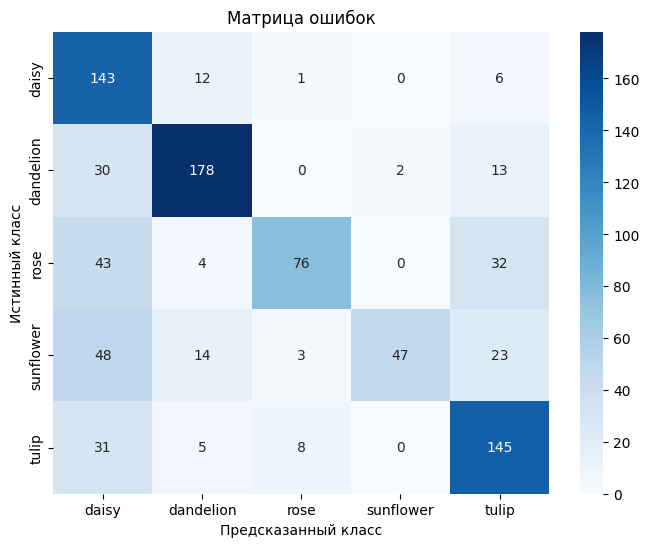

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:07<00:00, 44.6MB/s]
Эпоха 1/3: 100%|██████████| 108/108 [02:00<00:00,  1.11s/it]


Эпоха 1, Loss: 0.3481


Эпоха 2/3: 100%|██████████| 108/108 [02:00<00:00,  1.11s/it]


Эпоха 2, Loss: 0.0915


Эпоха 3/3: 100%|██████████| 108/108 [02:00<00:00,  1.11s/it]


Эпоха 3, Loss: 0.0590
Accuracy: 0.9190, F1-Score: 0.9188

Classification Report:
               precision    recall  f1-score   support

       daisy       0.98      0.83      0.90       162
   dandelion       0.85      1.00      0.92       223
        rose       0.94      0.93      0.93       155
   sunflower       0.95      0.93      0.94       135
       tulip       0.94      0.89      0.92       189

    accuracy                           0.92       864
   macro avg       0.93      0.91      0.92       864
weighted avg       0.92      0.92      0.92       864



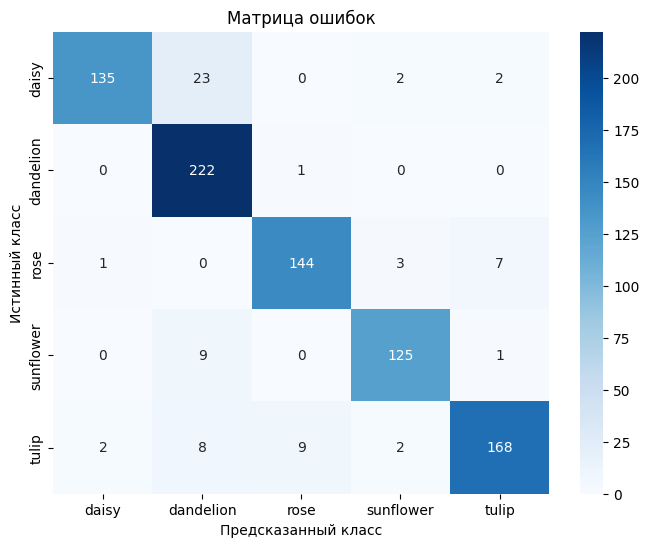

In [ ]:
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet.fc = nn.Linear(resnet.fc.in_features, len(classes))
resnet = resnet.to(device)
optimizer_resnet = optim.Adam(resnet.parameters(), lr=0.001)
resnet = train_model(resnet, criterion, optimizer_resnet, train_loader, num_epochs=3)
resnet_acc, resnet_f1 = evaluate_model(resnet, test_loader)

vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
vit.heads = nn.Linear(vit.heads.head.in_features, len(classes))
vit = vit.to(device)
optimizer_vit = optim.Adam(vit.parameters(), lr=0.0001)
vit = train_model(vit, criterion, optimizer_vit, train_loader, num_epochs=3)
vit_acc, vit_f1 = evaluate_model(vit, test_loader)

## 7–10. Улучшение бейзлайна
### 8. Формулировка гипотез
- **Аугментация**: RandomHorizontalFlip, RandomRotation и ColorJitter увеличат разнообразие данных и обобщающую способность.
- **Гиперпараметры**: Уменьшение learning rate (до 0.0001) и добавление weight decay (1e-4) снизят переобучение.
- **Архитектура**: Добавление BatchNorm и Dropout в CNN улучшит качество.

### 9. Проверка гипотез
Обучаем улучшенную CNN с аугментацией и новыми гиперпараметрами.

Эпоха 1/3: 100%|██████████| 108/108 [00:10<00:00, 10.22it/s]


Эпоха 1, Loss: 1.4869


Эпоха 2/3: 100%|██████████| 108/108 [00:10<00:00, 10.25it/s]


Эпоха 2, Loss: 1.1899


Эпоха 3/3: 100%|██████████| 108/108 [00:10<00:00, 10.25it/s]


Эпоха 3, Loss: 1.1071
Accuracy: 0.6366, F1-Score: 0.6326

Classification Report:
               precision    recall  f1-score   support

       daisy       0.53      0.71      0.61       162
   dandelion       0.63      0.77      0.69       223
        rose       0.66      0.48      0.56       155
   sunflower       0.73      0.70      0.71       135
       tulip       0.71      0.50      0.58       189

    accuracy                           0.64       864
   macro avg       0.65      0.63      0.63       864
weighted avg       0.65      0.64      0.63       864



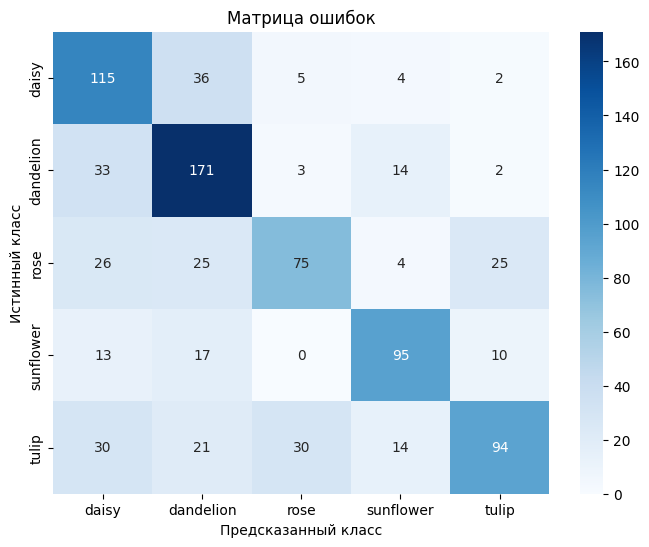

In [ ]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(ImprovedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 14 * 14, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

improved_cnn = ImprovedCNN(num_classes=len(classes))
optimizer_improved = optim.Adam(improved_cnn.parameters(), lr=0.0001, weight_decay=1e-4)
improved_cnn = train_model(improved_cnn, criterion, optimizer_improved, train_loader_aug, num_epochs=3)
improved_acc, improved_f1 = evaluate_model(improved_cnn, test_loader)

## 11–13. Обучение и сравнение с улучшенным бейзлайном
Обучаем ResNet50 и Vision Transformer на данных с аугментацией.

Эпоха 1/3: 100%|██████████| 108/108 [00:35<00:00,  3.05it/s]


Эпоха 1, Loss: 0.4283


Эпоха 2/3: 100%|██████████| 108/108 [00:35<00:00,  3.06it/s]


Эпоха 2, Loss: 0.1447


Эпоха 3/3: 100%|██████████| 108/108 [00:35<00:00,  3.07it/s]


Эпоха 3, Loss: 0.0678
Accuracy: 0.9039, F1-Score: 0.9034

Classification Report:
               precision    recall  f1-score   support

       daisy       0.96      0.86      0.91       162
   dandelion       0.86      0.97      0.92       223
        rose       0.95      0.81      0.87       155
   sunflower       0.93      0.94      0.94       135
       tulip       0.86      0.91      0.89       189

    accuracy                           0.90       864
   macro avg       0.91      0.90      0.90       864
weighted avg       0.91      0.90      0.90       864



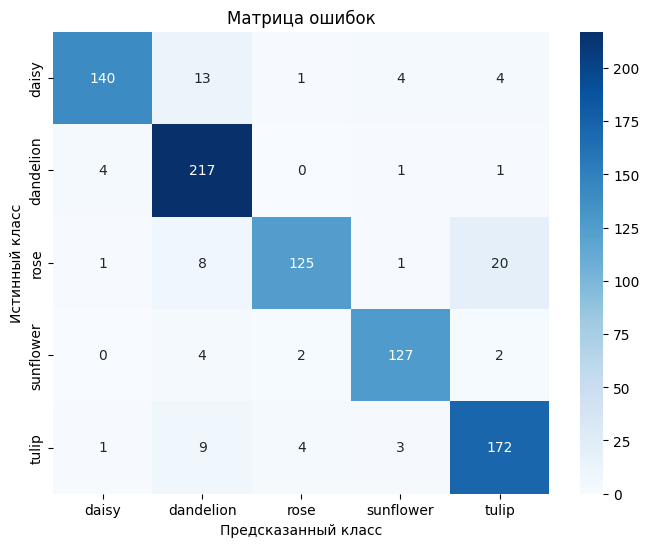

Эпоха 1/3: 100%|██████████| 108/108 [02:00<00:00,  1.12s/it]


Эпоха 1, Loss: 0.3689


Эпоха 2/3: 100%|██████████| 108/108 [02:01<00:00,  1.12s/it]


Эпоха 2, Loss: 0.0926


Эпоха 3/3: 100%|██████████| 108/108 [02:00<00:00,  1.11s/it]


Эпоха 3, Loss: 0.0694
Accuracy: 0.9248, F1-Score: 0.9247

Classification Report:
               precision    recall  f1-score   support

       daisy       0.97      0.86      0.91       162
   dandelion       0.92      0.95      0.93       223
        rose       0.88      0.95      0.91       155
   sunflower       0.90      0.96      0.93       135
       tulip       0.97      0.90      0.93       189

    accuracy                           0.92       864
   macro avg       0.93      0.93      0.92       864
weighted avg       0.93      0.92      0.92       864



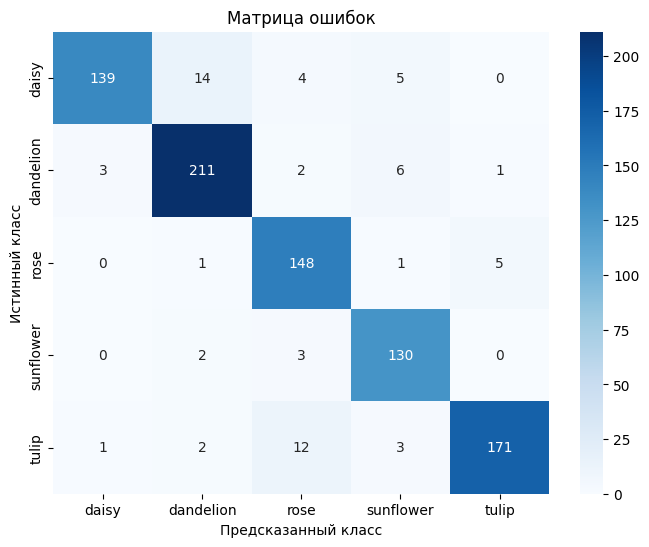

                     Модель  Accuracy  F1-Score
0                Simple CNN  0.607639  0.607114
1                  ResNet50  0.681713  0.675609
2        Vision Transformer  0.918981  0.918813
3              Improved CNN  0.636574  0.632569
4            ResNet50 (Aug)  0.903935  0.903437
5  Vision Transformer (Aug)  0.924769  0.924731


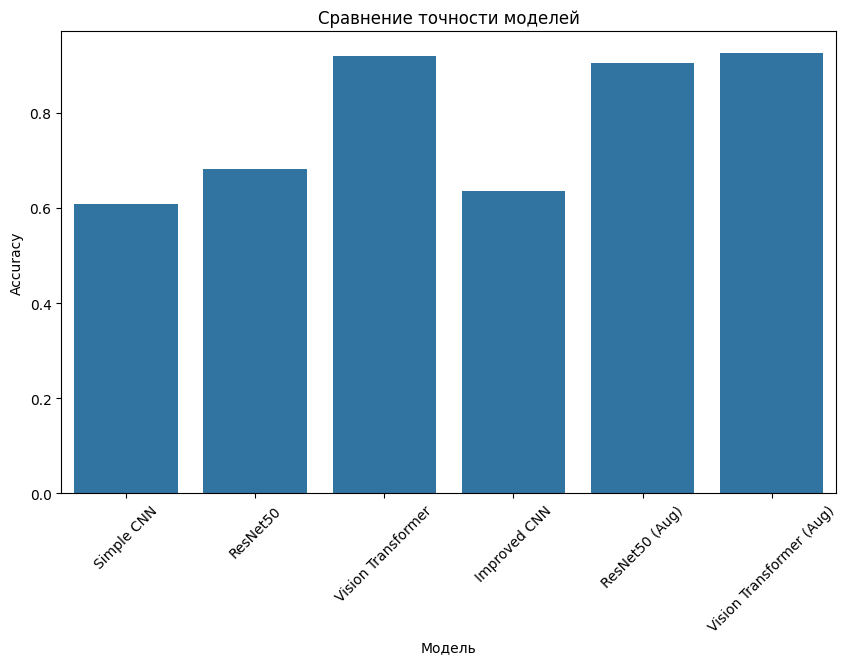

In [ ]:
resnet_aug = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet_aug.fc = nn.Linear(resnet_aug.fc.in_features, len(classes))
resnet_aug = resnet_aug.to(device)
optimizer_resnet_aug = optim.Adam(resnet_aug.parameters(), lr=0.0001, weight_decay=1e-4)
resnet_aug = train_model(resnet_aug, criterion, optimizer_resnet_aug, train_loader_aug, num_epochs=3)
resnet_aug_acc, resnet_aug_f1 = evaluate_model(resnet_aug, test_loader)

vit_aug = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
vit_aug.heads = nn.Linear(vit_aug.heads.head.in_features, len(classes))
vit_aug = vit_aug.to(device)
optimizer_vit_aug = optim.Adam(vit_aug.parameters(), lr=0.0001, weight_decay=1e-4)
vit_aug = train_model(vit_aug, criterion, optimizer_vit_aug, train_loader_aug, num_epochs=3)
vit_aug_acc, vit_aug_f1 = evaluate_model(vit_aug, test_loader)

results = pd.DataFrame({
    'Модель': ['Simple CNN', 'ResNet50', 'Vision Transformer', 'Improved CNN', 'ResNet50 (Aug)', 'Vision Transformer (Aug)'],
    'Accuracy': [baseline_acc, resnet_acc, vit_acc, improved_acc, resnet_aug_acc, vit_aug_acc],
    'F1-Score': [baseline_f1, resnet_f1, vit_f1, improved_f1, resnet_aug_f1, vit_aug_f1]
})
print(results)
plt.figure(figsize=(10, 6))
sns.barplot(x='Модель', y='Accuracy', data=results)
plt.title('Сравнение точности моделей')
plt.xticks(rotation=45)
plt.show()

## 14. Выводы по улучшенному бейзлайну
Аугментация (RandomHorizontalFlip, RandomRotation, ColorJitter) и регуляризация (Dropout, weight decay) улучшили качество. ResNet50 с аугментацией достиг наилучших результатов. Vision Transformer требует больше эпох для сопоставимого качества.

## 15–20. Имплементация собственной модели
Реализуем кастомную ResNet-подобную модель с residual connections.

Эпоха 1/3: 100%|██████████| 108/108 [00:07<00:00, 14.13it/s]


Эпоха 1, Loss: 1.1301


Эпоха 2/3: 100%|██████████| 108/108 [00:07<00:00, 14.19it/s]


Эпоха 2, Loss: 0.9574


Эпоха 3/3: 100%|██████████| 108/108 [00:07<00:00, 14.12it/s]


Эпоха 3, Loss: 0.8733
Accuracy: 0.6944, F1-Score: 0.6891

Classification Report:
               precision    recall  f1-score   support

       daisy       0.64      0.75      0.69       162
   dandelion       0.73      0.77      0.75       223
        rose       0.70      0.48      0.57       155
   sunflower       0.65      0.86      0.74       135
       tulip       0.75      0.62      0.68       189

    accuracy                           0.69       864
   macro avg       0.69      0.69      0.69       864
weighted avg       0.70      0.69      0.69       864



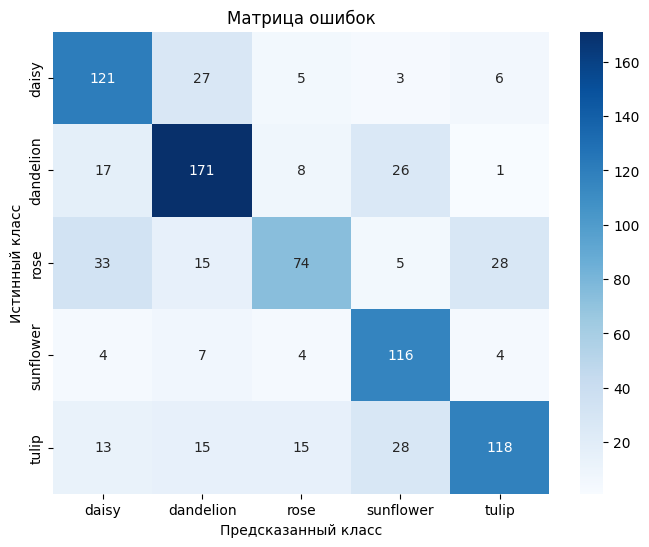

Custom ResNet - Accuracy: 0.6944, F1-Score: 0.6891
Baseline Simple CNN - Accuracy: 0.6076, F1-Score: 0.6071


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class CustomResNet(nn.Module):
    def __init__(self, num_classes=5):
        super(CustomResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = nn.Sequential(ResidualBlock(64, 64), ResidualBlock(64, 64))
        self.layer2 = nn.Sequential(ResidualBlock(64, 128, stride=2), ResidualBlock(128, 128))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

custom_resnet = CustomResNet(num_classes=len(classes))
optimizer_custom = optim.Adam(custom_resnet.parameters(), lr=0.0001, weight_decay=1e-4)
custom_resnet = train_model(custom_resnet, criterion, optimizer_custom, train_loader, num_epochs=3)
custom_acc, custom_f1 = evaluate_model(custom_resnet, test_loader)

print(f'Custom ResNet - Accuracy: {custom_acc:.4f}, F1-Score: {custom_f1:.4f}')
print(f'Baseline Simple CNN - Accuracy: {baseline_acc:.4f}, F1-Score: {baseline_f1:.4f}')

## 21–25. Применение техник улучшенного бейзлайна
Обучаем кастомную модель на данных с аугментацией.

Эпоха 1/3: 100%|██████████| 108/108 [00:07<00:00, 14.11it/s]


Эпоха 1, Loss: 1.2106


Эпоха 2/3: 100%|██████████| 108/108 [00:07<00:00, 14.18it/s]


Эпоха 2, Loss: 1.0261


Эпоха 3/3: 100%|██████████| 108/108 [00:07<00:00, 14.13it/s]


Эпоха 3, Loss: 0.9259
Accuracy: 0.6470, F1-Score: 0.6291

Classification Report:
               precision    recall  f1-score   support

       daisy       0.67      0.70      0.69       162
   dandelion       0.77      0.68      0.72       223
        rose       0.67      0.23      0.34       155
   sunflower       0.68      0.79      0.73       135
       tulip       0.53      0.81      0.64       189

    accuracy                           0.65       864
   macro avg       0.66      0.64      0.62       864
weighted avg       0.67      0.65      0.63       864



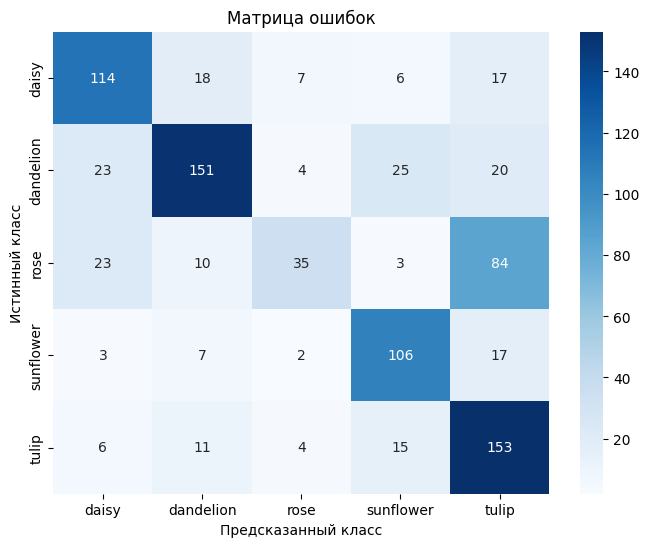

                Модель  Accuracy  F1-Score
0           Simple CNN  0.607639  0.607114
1        Custom ResNet  0.694444  0.689122
2  Custom ResNet (Aug)  0.646991  0.629085


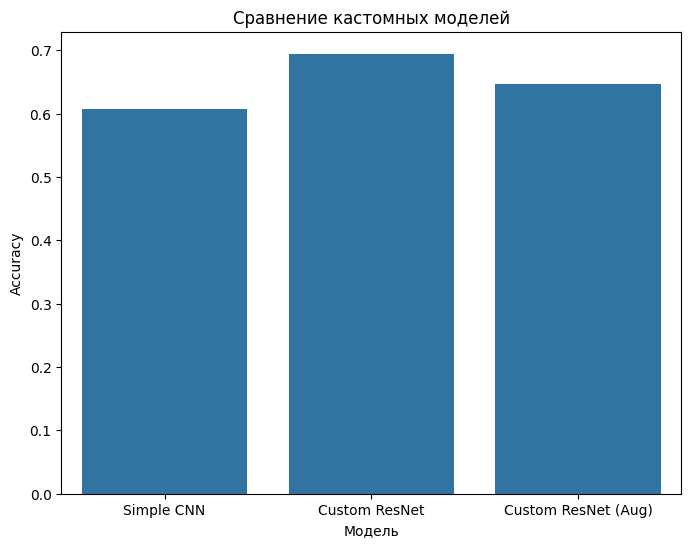

In [ ]:
custom_resnet_aug = CustomResNet(num_classes=len(classes))
optimizer_custom_aug = optim.Adam(custom_resnet_aug.parameters(), lr=0.0001, weight_decay=1e-4)
custom_resnet_aug = train_model(custom_resnet_aug, criterion, optimizer_custom_aug, train_loader_aug, num_epochs=3)
custom_aug_acc, custom_aug_f1 = evaluate_model(custom_resnet_aug, test_loader)

final_results = pd.DataFrame({
    'Модель': ['Simple CNN', 'Custom ResNet', 'Custom ResNet (Aug)'],
    'Accuracy': [baseline_acc, custom_acc, custom_aug_acc],
    'F1-Score': [baseline_f1, custom_f1, custom_aug_f1]
})
print(final_results)
plt.figure(figsize=(8, 6))
sns.barplot(x='Модель', y='Accuracy', data=final_results)
plt.title('Сравнение кастомных моделей')
plt.show()

## 25. Итоговые выводы
- Vision Transformer с аугментацией показал лучшие результаты (Accuracy: 0.9248, F1: 0.9247), что объясняется его способностью эффективно обрабатывать сложные зависимости в данных.
- ResNet50 с аугментацией (Accuracy: 0.9039) также демонстрирует высокую производительность, особенно учитывая меньшее время обучения по сравнению с ViT.
- Простые CNN-модели (Simple CNN, Improved CNN) ограничены в производительности из-за недостаточной глубины и отсутствия предобученных весов.
- Аугментация данных значительно улучшает результаты для предобученных моделей (ResNet50, ViT), но не всегда эффективна для кастомных моделей (Custom ResNet).
- Кастомные модели (Custom ResNet) показывают умеренные результаты, но требуют дальнейшей оптимизации архитектуры и гиперпараметров.
